# Sparse source reconstruction of SLACS lenses

__Author__ : Aymeric Galan

__Created__ : 9/04/20

__Updated__ : 1/09/20

This notebook applies the SLITronomy solver to reconstruct the source galaxy on a grid of pixels, subject to the constraints of sparsity in wavelet space and positivity in direct space. It also properly compare the reconstructions with analytical results obtained with a shapelet+Sérsic model.

Lens models were obtained with the workflow described in https://arxiv.org/abs/2008.11724. A special thanks to A. Shajib for sharing the lenstronomy lens model parameters.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

__author__ = 'aymgal'

import os
import pprint
import h5py
import time
import copy
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.colors import LogNorm

from lenstronomy.Util import util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.LightModel.Profiles.starlets import SLIT_Starlets
from lenstronomy.ImSim.MultiBand.single_band_multi_model import SingleBandMultiModel
from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit

from slitronomy.Util import plot_util
from slitronomy.Util import metrics_util
from image_mask import ImageMask

## General settings for this notebook

- `subtract_lens_light`: if `True`, subtract the lens light from analytical model, and mask potential residuals at close to the lens center.
- `supersampling_factor_source`: supersampling resolution of source plane grid (aka $r_{\rm pix}$ in the paper).
- `object_name`: select teh SLACS system to model. Currently, systems available are SDSSJ0959+0410, SDSSJ1250+0523, SDSSJ1627-0053, SDSSJ1630+4520.

In [2]:
subtract_lens_light = True
supersampling_factor_source = 3

#object_name = 'SDSSJ1627-0053'
#object_name = 'SDSSJ1630+4520'
object_name = 'SDSSJ1250+0523'
#object_name = 'SDSSJ0959+0410'

#### Choice of colormaps

In [3]:
cmap_default = plt.get_cmap('viridis')
cmap_residuals = plt.get_cmap('RdBu_r')
cmap_flux = copy.copy(plt.get_cmap('cubehelix'))
cmap_flux.set_bad(color='black', alpha=1)
cmap_flux_with_neg = copy.copy(plt.get_cmap('cubehelix'))
cmap_flux_with_neg.set_bad(color='#222222', alpha=1)  # emphasize -negative pixels when in log scale

## Load image cutout

In [4]:
data_path = os.path.join('data', 'SLACS')
hst_band_name = 'F555W'

if object_name == 'SDSSJ0959+0410':
    lens_mask_outer_radius = 3
elif object_name == 'SDSSJ1250+0523':
    lens_mask_inner_radius = 0.4
    lens_mask_outer_radius = 2.8
elif object_name == 'SDSSJ1627-0053':
    lens_mask_inner_radius = 0.6
    lens_mask_outer_radius = 2.2
elif object_name == 'SDSSJ1630+4520':
    lens_mask_inner_radius = 0.6
    lens_mask_outer_radius = 3

image_file = 'image_{}_{}.h5'.format(object_name, hst_band_name)
psf_file = 'psf_{}_{}.h5'.format(object_name, hst_band_name)
result_file = 'result_{}_{}.pkl'.format(object_name, hst_band_name)

f= h5py.File(os.path.join(data_path, image_file), 'r')
data_reduced = f['image_data'][()]
background_rms = f['background_rms'][()]
exposure_map = f['exposure_time'][()]
ra_at_xy_0 = f['ra_at_xy_0'][()]
dec_at_xy_0 = f['dec_at_xy_0'][()]
transform_pix2angle = f['transform_pix2angle'][()]
f.close()
print(data_reduced.shape)

f = h5py.File(os.path.join(data_path, psf_file), 'r')
psf_kernel = f['kernel_point_source'][()]
f.close()
print(psf_kernel.sum(), psf_kernel.shape)

# setup with same coordinates conventions than model
kwargs_data = {
    'image_data': data_reduced,
    'exposure_time': exposure_map,
    'background_rms': background_rms,
    'ra_at_xy_0': ra_at_xy_0,
    'dec_at_xy_0': dec_at_xy_0,
    'transform_pix2angle': transform_pix2angle,
}
kwargs_psf = {
    'psf_type': 'PIXEL',
    'kernel_point_source': psf_kernel,
}
kwargs_numerics = {
    'supersampling_factor': 3,  # supersampling used by Anowar
}
single_band_list = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [single_band_list]
multi_band_type = 'single-band'

(110, 110)
0.9951447 (41, 41)


## Display imaging data, exposure map and PSF

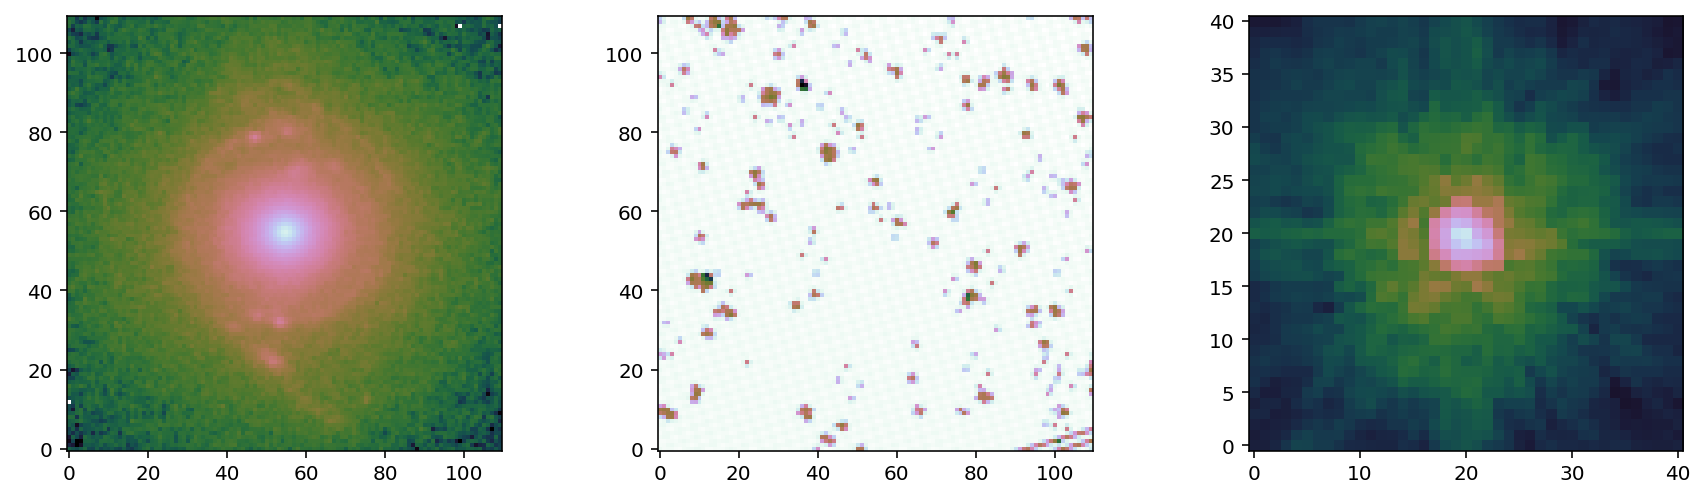

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax = axes[0]
ax.imshow(data_reduced, origin='lower', cmap='cubehelix', norm=LogNorm(1e-3, 1e1))
ax = axes[1]
ax.imshow(exposure_map, origin='lower', cmap='cubehelix')
ax = axes[2]
ax.imshow(psf_kernel, origin='lower', cmap='cubehelix', norm=LogNorm(1e-6, 1e0))
plt.show()

## Retrieve model parameters and create lenstronomy classes

In [6]:
# get fit parameters
kwargs_results, kwargs_model = pkl.load(open(os.path.join(data_path, result_file), 'rb'))
pprint.pprint(kwargs_model)

{'lens_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'],
 'lens_model_list': ['PEMD', 'SHEAR_GAMMA_PSI'],
 'source_light_model_list': ['SERSIC_ELLIPSE', 'SHAPELETS']}


In [7]:
# create required lenstronomy classes
likelihood_mask_list = None # kwargs_likelihood['image_likelihood_mask_list']
band_index = 0

band_model_fit = SingleBandMultiModel(multi_band_list, multi_band_type, kwargs_model, 
                                      likelihood_mask_list=likelihood_mask_list, 
                                      band_index=band_index)

data_class = band_model_fit.Data
psf_class = band_model_fit.PSF
lens_model_class_fit = band_model_fit.LensModel

kwargs_lens_fit = kwargs_results['kwargs_lens']
kwargs_lens_light_fit = kwargs_results['kwargs_lens_light']
kwargs_source_fit = kwargs_results['kwargs_source']

In [8]:
pprint.pprint(kwargs_results['kwargs_lens'])
pprint.pprint(kwargs_lens_fit)

[{'center_x': 0.003902853042577458,
  'center_y': -0.039530909508715184,
  'e1': -0.0019126846167156373,
  'e2': -0.03045114420594998,
  'gamma': 1.9255832173763139,
  'theta_E': 1.1185199423367738},
 {'dec_0': 0,
  'gamma_ext': 0.004982685666296505,
  'psi_ext': -0.9955841948348914,
  'ra_0': 0}]
[{'center_x': 0.003902853042577458,
  'center_y': -0.039530909508715184,
  'e1': -0.0019126846167156373,
  'e2': -0.03045114420594998,
  'gamma': 1.9255832173763139,
  'theta_E': 1.1185199423367738},
 {'dec_0': 0,
  'gamma_ext': 0.004982685666296505,
  'psi_ext': -0.9955841948348914,
  'ra_0': 0}]


## Prepare data for SLITronomy reconstruction

### Subtract lens light (if required)

In [9]:
if subtract_lens_light:
    fit_image = band_model_fit.lens_surface_brightness(kwargs_lens_light_fit)
    data_lens_sub = data_class.data - fit_image
else:
    data_lens_sub = data_class.data.copy()

# new estimation of the background noise level 
background_rms_sub = 1.48 * np.median(np.abs(data_lens_sub-np.median(data_lens_sub)))

# where pixels are negative, fill with noise
no_negative_pixels = False
if no_negative_pixels:
    neg_indices = (data_lens_sub <= 0)
    data_lens_sub[neg_indices] = background_rms_sub*np.random.randn(*data_lens_sub.shape)[neg_indices]

# update data
kwargs_data_sub = copy.deepcopy(kwargs_data)

# udpate imaging data
kwargs_data_sub['image_data'] = data_lens_sub

# update noise map to make it gaussian-noise only ?
only_gaussian_noise = False
if only_gaussian_noise:
    kwargs_data_sub['background_rms'] = background_rms_sub
    kwargs_data_sub['noise_map'] = background_rms_sub * np.ones_like(data_lens_sub)

print(kwargs_data_sub.keys())

# data class with preprocessed data
data_sub_class = ImageData(**kwargs_data_sub)

dict_keys(['image_data', 'exposure_time', 'background_rms', 'ra_at_xy_0', 'dec_at_xy_0', 'transform_pix2angle'])


### Display data effectively used for sparse reconstruction

/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


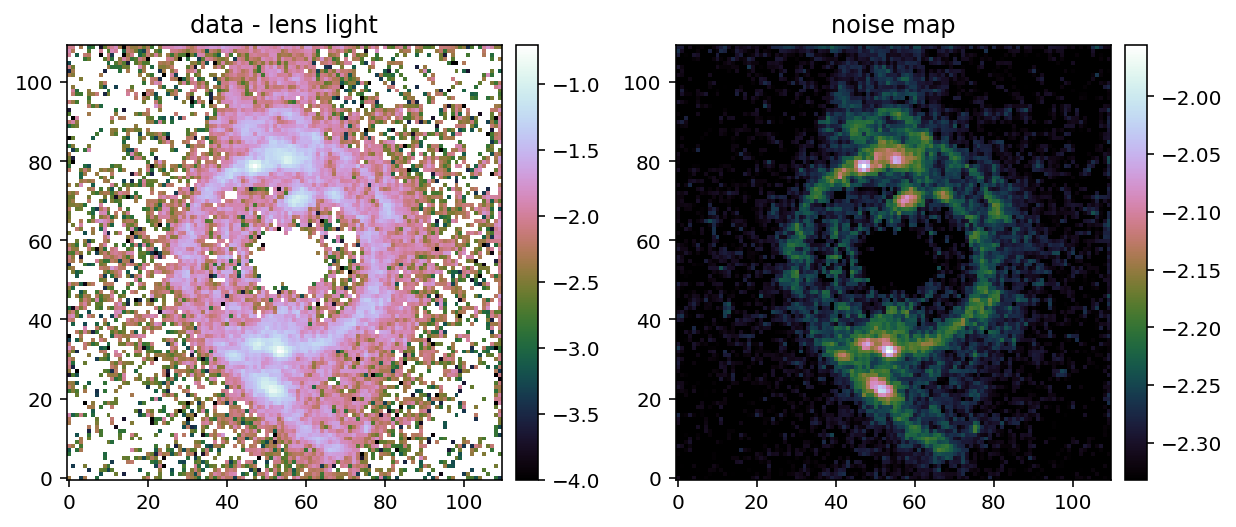

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
ax.set_title("data - lens light")
im = ax.imshow(np.log10(data_lens_sub), origin='lower', cmap='cubehelix', vmin=-4)
plot_util.nice_colorbar(im)
ax = axes[1]
ax.set_title("noise map")
im = ax.imshow(np.log10(np.sqrt(data_sub_class.C_D)), origin='lower', cmap='cubehelix')
plot_util.nice_colorbar(im)
plt.show()

### Create mask for excluding certain areas from the likelihood

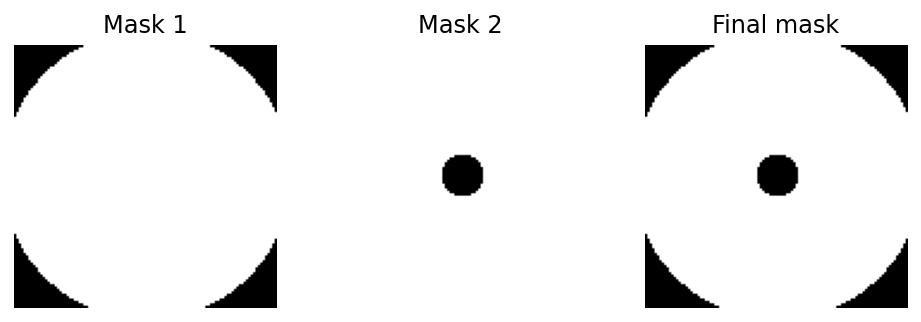

/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/matplotlib/colors.py:1207: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


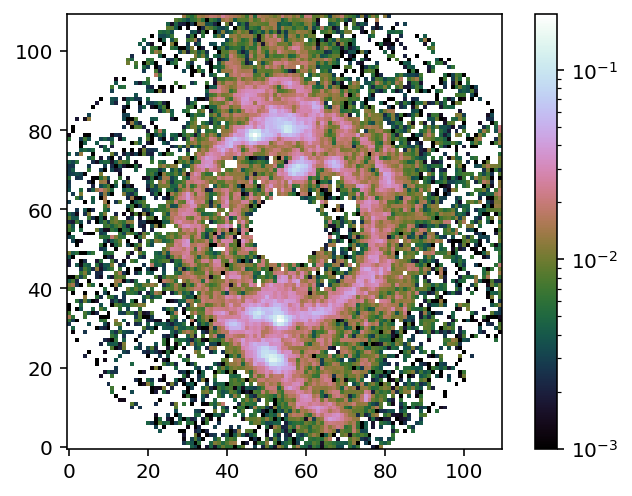

In [11]:
# defines a suitable mask because subtraction is not perfect
if subtract_lens_light:
    if object_name == 'SDSSJ0959+0410':
        # this one needs a specific mask due to inaccurate lens light modelling
        pixel_width = data_sub_class.pixel_width
        mask_kwargs = {
            'mask_type': 'ellipse',
            'radius_list': [lens_mask_outer_radius] + [0.5], 
            'axis_ratio_list': [1] + [0.8], 
            'angle_list': [0] + [-20], 
            'center_list': [None] + [(pixel_width*54, pixel_width*56)],
            'inverted_list': [False] + [True], 
            'operation_list': ['inter'],
        }
    else:
        mask_kwargs = {
            'mask_type': 'circle',
            'radius_list': [lens_mask_outer_radius] + [lens_mask_inner_radius], 
            'center_list': [None] + [None],
            'inverted_list': [False] + [True], 
            'operation_list': ['inter'],
        }
else:
    mask_kwargs = {
        'mask_type': 'circle',
        'radius_list': [lens_mask_outer_radius],
        'center_list': [None],
        'inverted_list': [False],
    }
imgMask = ImageMask(mask_shape=data_sub_class.data.shape,
                    delta_pix=data_sub_class.pixel_width,
                    **mask_kwargs)
mask_sparsefit = imgMask.get_mask(show_details=True)

if mask_sparsefit is not None:
    data_masked = data_sub_class.data.copy()
    data_masked[mask_sparsefit == 0] = np.nan
    plt.imshow(data_masked, origin='lower',  cmap='cubehelix', norm=LogNorm(1e-3))
    plt.colorbar()
    plt.show()

### Prepare for sparse modelling

If lens light was not removed, SLITronomy will solve for both source and lens on pixelated grids.

In [12]:
source_model_list_sparsefit = ['SLIT_STARLETS']
kwargs_source_sparsefit = [{'n_scales': 6}]
source_model_class_sparsefit = LightModel(light_model_list=source_model_list_sparsefit)

if not subtract_lens_light:
    lens_light_model_list_sparsefit = ['SLIT_STARLETS']
    n_pixels_lens = np.size(data_sub_class.data)
    kwargs_lens_light_sparsefit = [{'n_scales': 4}]
    lens_light_model_class_sparsefit = LightModel(light_model_list=lens_light_model_list_sparsefit)
else:
    kwargs_lens_light_sparsefit = []
    lens_light_model_class_sparsefit = None

kwargs_special_sparsefit = {
    'delta_x_source_grid': 0,
    'delta_y_source_grid': 0,
}

kwargs_sparse_solver = {
    'supersampling_factor_source': supersampling_factor_source,
    'minimal_source_plane': True,
    'use_mask_for_minimal_source_plane': True,
    'min_num_pix_source': 50,
    
    'min_threshold': 3,  # 3-sigma
    'threshold_increment_high_freq': 2,  # 2 + 3 = 5-sigma
    
    'verbose': True,
    'show_steps': False,
}
if subtract_lens_light:
    kwargs_sparse_solver.update({
        'include_regridding_error': False,
        'threshold_decrease_type': 'exponential',
        'num_iter_source': 20,
        'num_iter_weights': 2,
    })
else:
    kwargs_sparse_solver.update({
        'include_regridding_error': False,
        'threshold_decrease_type': 'linear',
        'num_iter_source': 20,
        'num_iter_lens': 10,
        'num_iter_global': 30,
        'num_iter_weights': 3,
    })

imageSparseFit = ImageSparseFit(data_sub_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class_fit,
                                source_model_class=source_model_class_sparsefit,
                                lens_light_model_class=lens_light_model_class_sparsefit,
                                likelihood_mask=mask_sparsefit,
                                kwargs_sparse_solver=kwargs_sparse_solver)

### Run the solver

In [13]:
start_time = time.time()
_ = imageSparseFit.image_sparse_solve(kwargs_lens_fit, 
                                      kwargs_source=kwargs_source_sparsefit,
                                      kwargs_lens_light=kwargs_lens_light_sparsefit,
                                      kwargs_special=kwargs_special_sparsefit)
end_time = time.time()
print("Runtime : {:.3f} s".format(end_time-start_time))

SizeablePlaneGrid: source grid has been reduced from 330 to 190 side pixels
=== iteration 0-0 === : loss+reg = 0.8516|nan, red-chi2 = 3.6849|nan, step_diff = 1.0593|nan
=== iteration 1-0 === : loss+reg = 0.5276|nan, red-chi2 = 2.4136|nan, step_diff = 0.6706|nan
Runtime : 1.048 s


### Display results and convergence diagnostics

Negative image pixels ? False (min = 3.35e-11)
Negative source pixels ? False (min = 0.00e+00)


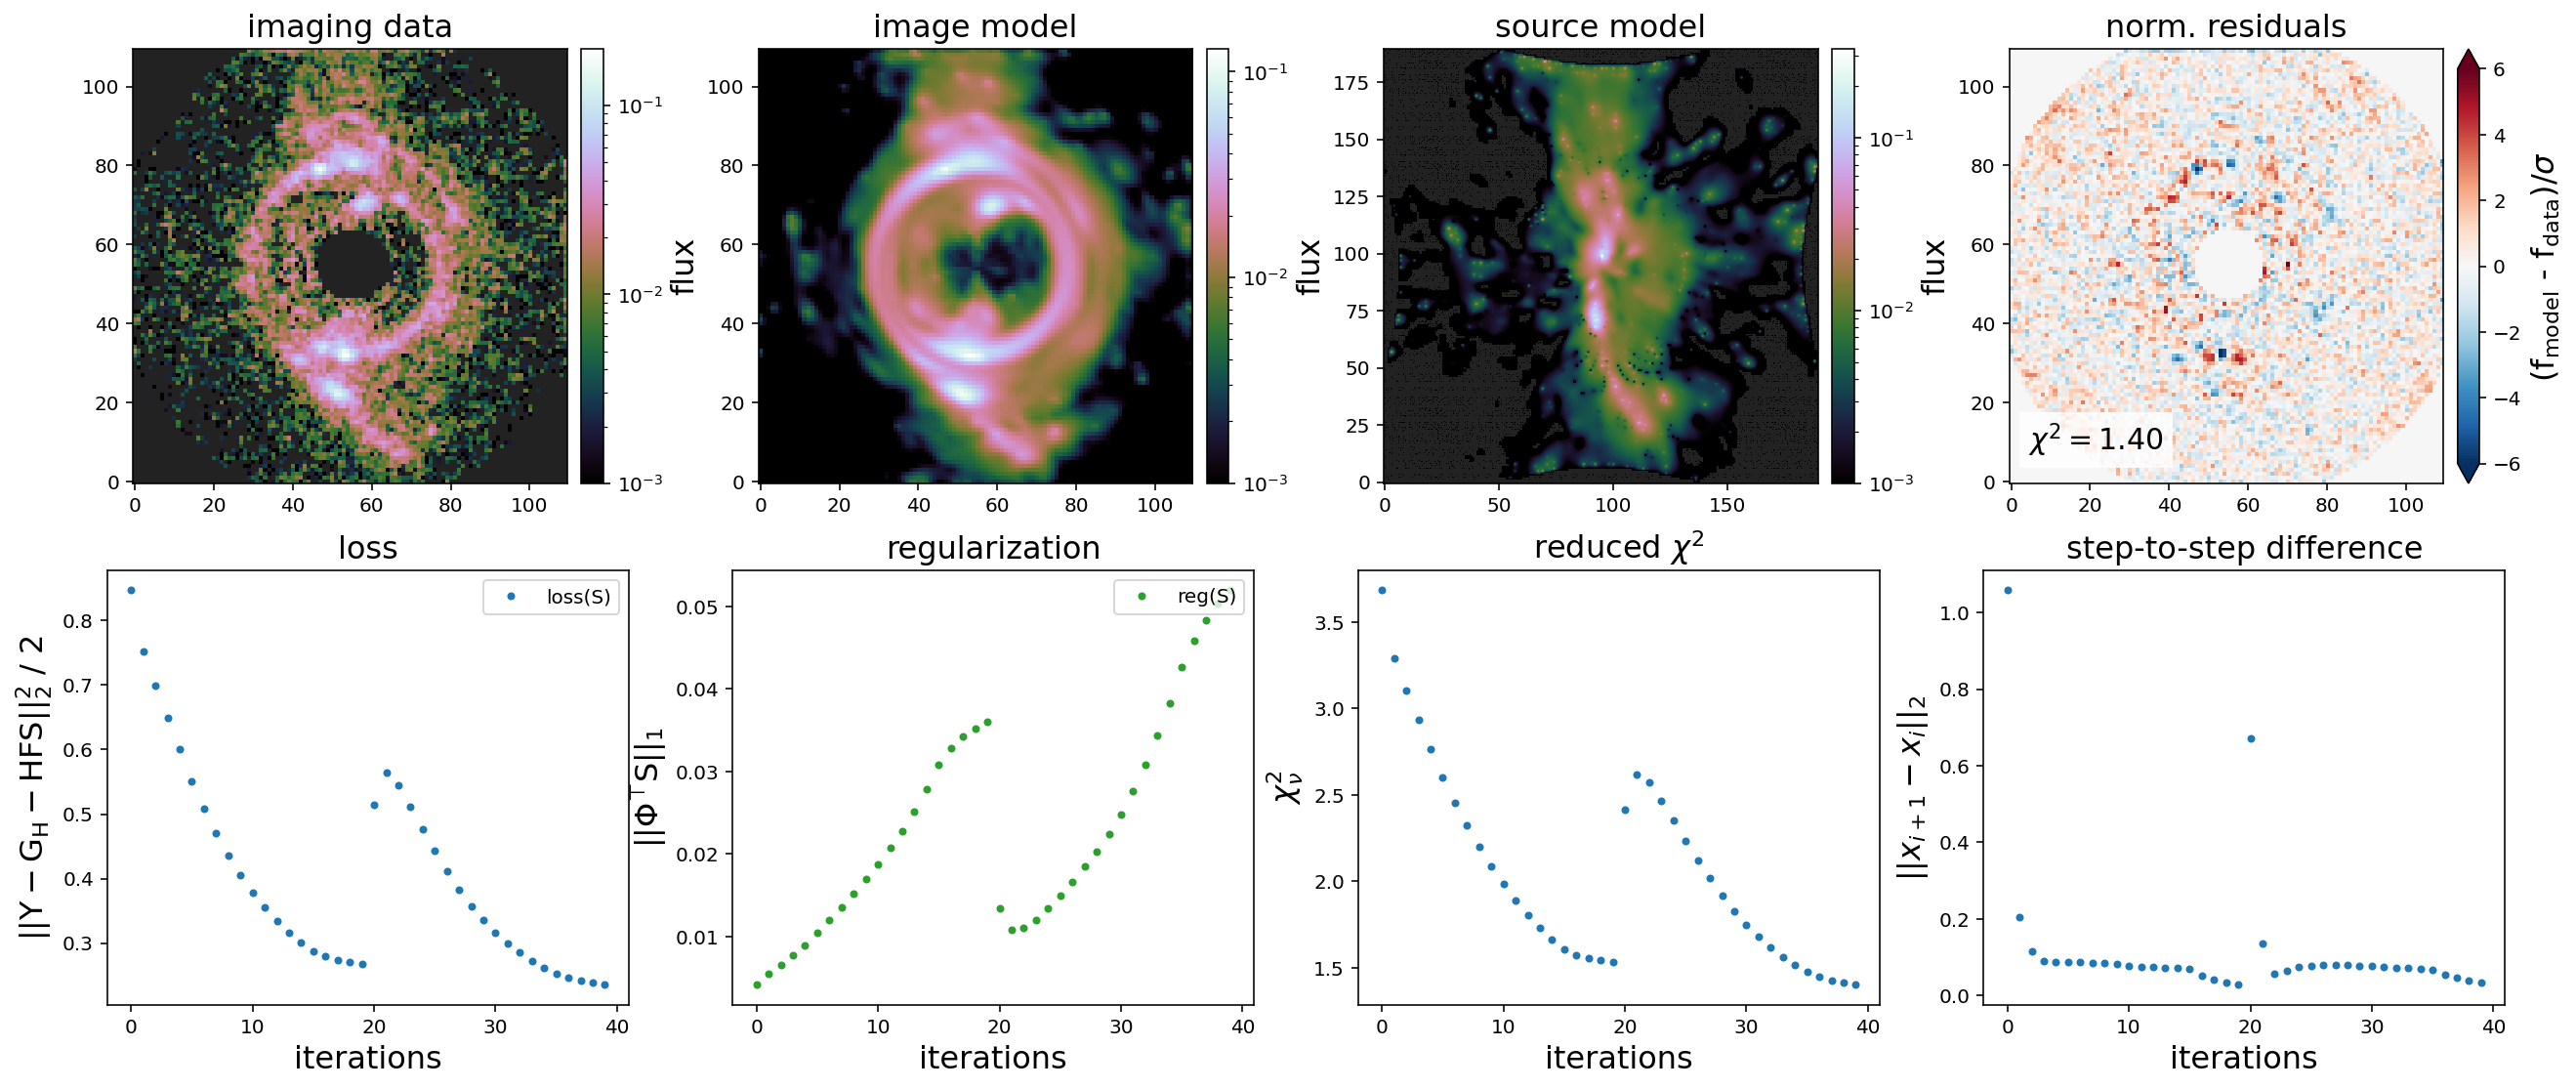

In [14]:
sparseSolver = imageSparseFit.sparseSolver
fig = sparseSolver.plot_results(log_scale=True, fontsize=16,
                                cmap_image=cmap_flux_with_neg,
                                cmap_source=cmap_flux_with_neg,
                                vmin_res=-6, vmax_res=6,
                                vmin_image=1e-3, 
                                vmin_source=1e-3)
plt.show()

## Comparison with shapelets reconstruction

### Project analytical models onto supersampled source grids 

In [15]:
# image model with shapelets
image_model_fit = band_model_fit.image(kwargs_lens=kwargs_lens_fit, kwargs_source=kwargs_source_fit, 
                                       kwargs_lens_light=kwargs_lens_light_fit, lens_light_add=False)

# source model with shapelets
source_model_fit = band_model_fit.source_surface_brightness(kwargs_source=kwargs_source_fit, de_lensed=True)
ra_grid_hd, dec_grid_hd = imageSparseFit.SourceNumerics.coordinates_evaluate
source_model_fit_hd = util.array2image(band_model_fit.SourceModel.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source_fit))
source_model_fit_hd *= imageSparseFit.SourceNumerics.grid_class.pixel_width**2

# image model with starlets
image_model_sparsefit = sparseSolver.image_model(unconvolved=False)

# source model with starlets NOT ORIENTED THE RIGHT WAY (due to interpolation function)
#source_model_sparsefit = imageSparseFit.source_surface_brightness(kwargs_source=kwargs_source_sparsefit, de_lensed=True)
from slitronomy.Util.util import array2cube
amp_cube = array2cube(kwargs_source_sparsefit[0]['amp'], kwargs_source_sparsefit[0]['n_scales'], kwargs_source_sparsefit[0]['n_pixels'])
source_model_sparsefit = SLIT_Starlets(thread_count=8).function_2d(amp_cube, kwargs_source_sparsefit[0]['n_scales'], kwargs_source_sparsefit[0]['n_pixels'])


### Setup final comparison plot

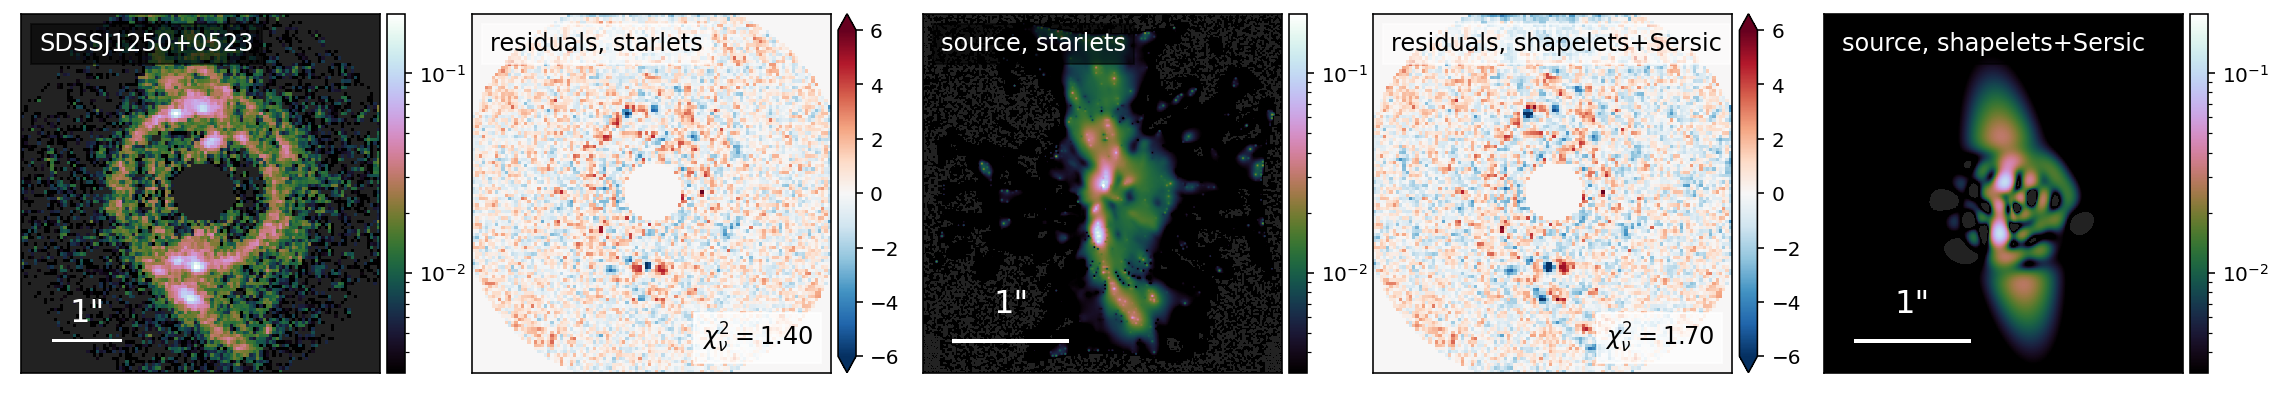

In [16]:
def add_scale_bar(ax, image_size, pixel_size, size_arcsec=1, color='white', fontsize=16):
    bott_left_x, bott_left_y = 0.08*image_size, 0.08*image_size
    width, height = float(size_arcsec)/pixel_size, 0.01*image_size
    bar = patches.Rectangle((bott_left_x, bott_left_y), width, height, facecolor=color)
    ax.add_patch(bar)
    text_offset_y = 0.2/pixel_size
    text = '{}"'.format(size_arcsec)
    ax.text(bott_left_x+width/2., bott_left_y+text_offset_y, text, color=color, fontsize=fontsize, 
            horizontalalignment='center', verticalalignment='bottom')

def add_title_box(ax, text, fontsize=16, txt_color='white', bg_color='black'):
    ax.text(0.05, 0.95, text, color=txt_color, fontsize=fontsize, 
            horizontalalignment='left', verticalalignment='top',
            transform=ax.transAxes, bbox={'color': bg_color, 'alpha': 0.5})
    
def add_text_box(ax, text, loc='right', fontsize=16, txt_color='black', bg_color='white'):
    if loc == 'right':
        x, y = 0.95, 0.05
        ha, va = 'right', 'bottom'
    elif loc == 'left':
        x, y = 0.05, 0.05
        ha, va = 'left', 'bottom'
    ax.text(x, y, text, color=txt_color, fontsize=fontsize, 
            horizontalalignment=ha, verticalalignment=va,
            transform=ax.transAxes, bbox={'color': bg_color, 'alpha': 0.7})

# flux value limits
image_vmin  = 10**(-2.5)
image_vmax  = data_lens_sub.max()
source_vmin = 10**(-2.5)
source_vmax = image_vmax #10**(0)

# residuals value limits (symmetric)
image_clim  = 6    # in noise units

# frame limits for source plots
n = len(source_model_sparsefit)
source_xlim = (int(n/5), int(4*n/5))
source_ylim = (int(n/5), int(4*n/5))

# setup the figure layout
#fig, axes = plt.subplots(1, 7, figsize=(20, 3.5), gridspec_kw={'width_ratios': [1]*5+[0.05]*2})
fig, axes = plt.subplots(1, 5, figsize=(20, 3.3))

# plot 1: imaging data
ax = axes[0]
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
add_title_box(ax, object_name, fontsize=12)
add_scale_bar(ax, data_sub_class.num_pixel_axes[0], data_sub_class.pixel_width)
im = ax.imshow(data_lens_sub * mask_sparsefit, origin='lower', cmap=cmap_flux_with_neg,
               norm=LogNorm(image_vmin, image_vmax))
plot_util.nice_colorbar(im, pad=0.05, fontsize=12) #, label="flux"

# plot 2: STARLETS normalized residuals
image_red_res = (image_model_sparsefit - data_lens_sub)/np.sqrt(data_sub_class.C_D) * mask_sparsefit
num_data_points = image_red_res[mask_sparsefit == 1].size
ax = axes[1]
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
add_title_box(ax, "residuals, starlets", fontsize=12, txt_color='black', bg_color='white')
imr = ax.imshow(image_red_res, origin='lower', cmap=cmap_residuals, 
               vmin=-image_clim, vmax=image_clim)
add_text_box(ax, r"$\chi^2_\nu=${:.2f}".format(metrics_util.chi2_nu(image_red_res, num_data_points)), 
             fontsize=12)
plot_util.nice_colorbar_residuals(imr, image_red_res, -image_clim, image_clim, pad=0.05, fontsize=12) #, label=r"$({\rm f}_{\rm model}-{\rm f}_{\rm data})/\sigma$")

# plot 3: STARLETS source model
ax = axes[2]
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
add_title_box(ax, "source, starlets", fontsize=12)
add_scale_bar(ax, source_xlim[1]-source_xlim[0], kwargs_source_sparsefit[0]['scale'])
im = ax.imshow(source_model_sparsefit[source_ylim[0]:source_ylim[1], source_xlim[0]:source_xlim[1]], origin='lower', cmap=cmap_flux_with_neg,
               norm=LogNorm(source_vmin, source_vmax))
plot_util.nice_colorbar(im, pad=0.05, fontsize=12) #,label="flux"

# plot 4: SHAPELETS normalized residuals
image_red_res = (image_model_fit - data_lens_sub)/np.sqrt(data_sub_class.C_D) * mask_sparsefit
num_data_points = image_red_res[mask_sparsefit == 1].size
ax = axes[3]
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
add_title_box(ax, "residuals, shapelets+Sersic", fontsize=12, txt_color='black', bg_color='white')
im = ax.imshow(image_red_res, origin='lower', cmap=cmap_residuals, 
               vmin=-image_clim, vmax=image_clim)
add_text_box(ax, r"$\chi^2_\nu=${:.2f}".format(metrics_util.chi2_nu(image_red_res, num_data_points)), 
             fontsize=12)
plot_util.nice_colorbar_residuals(im, image_red_res, -image_clim, image_clim, pad=0.05, fontsize=12) #,label=r"$({\rm f}_{\rm model}-{\rm f}_{\rm data})/\sigma$")

# plot 5: SHAPELETS source model
ax = axes[4]
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
add_title_box(ax, "source, shapelets+Sersic", fontsize=12)
add_scale_bar(ax, source_xlim[1]-source_xlim[0], kwargs_source_sparsefit[0]['scale'])
im = ax.imshow(source_model_fit_hd[source_ylim[0]:source_ylim[1], source_xlim[0]:source_xlim[1]], origin='lower', cmap=cmap_flux_with_neg,
               norm=LogNorm(source_vmin, source_vmax))
plot_util.nice_colorbar(im, pad=0.05, fontsize=12) #,label="flux"

#cb = plot_util.std_colorbar(im, cax=axes[5], fontsize=12, label="flux")
#axes[5].yaxis.set_label_position('left')
#cb = plot_util.std_colorbar(imr, cax=axes[6], fontsize=12,
#                            label=r"$({\rm f}_{\rm model}-{\rm f}_{\rm data})/\sigma$")
#axes[6].yaxis.set_label_position('left')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0)
plt.show()

In [17]:
# save the figure
fig_name = 'SLACS_fixed-mass_{}_ssres{}.pdf'.format(object_name, supersampling_factor_source)
fig_path = os.path.join('figures', fig_name)
#fig.savefig(fig_path, dpi=100, bbox_inches='tight')